### Car Sale Advertisements
**car**: manufacturer brand  
**price**: seller’s price in advertisement (in USD/доллар США)  
**body**: car body type  
**mileage**: as mentioned in advertisement (‘000 Km)  
**engV**: rounded engine volume (‘000 cubic cm) - объём двигателя  
**engType**: type of fuel (“Other” in this case should be treated as NA) - тип бензина    
**registration**: whether car registered in Ukraine or not - зарегистрирован ли автомобиль в Украине или нет    
**year**: year of production - год изготовления    
**model**: specific model name - модель  
**drive**: drive type - тип привода (rear - задний, front - передний, full - полноприводный)

In [270]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [271]:
df = pd.read_csv('car_ad1.csv' , encoding='latin-1')

In [272]:
print(df.shape)
df.head(10)

(9576, 10)


,car,price,body,mileage,engV,engType,registration,year,model,drive
0,Ford,15500.0,crossover,68,2.5,Gas,yes,2010,Kuga,full
1,Mercedes-Benz,20500.0,sedan,173,1.8,Gas,yes,2011,E-Class,rear
2,Mercedes-Benz,35000.0,other,135,5.5,Petrol,yes,2008,CL 550,rear
3,Mercedes-Benz,17800.0,van,162,1.8,Diesel,yes,2012,B 180,front
4,Mercedes-Benz,33000.0,vagon,91,NaN,Other,yes,2013,E-Class,NaN
5,Nissan,16600.0,crossover,83,2.0,Petrol,yes,2013,X-Trail,full
6,Honda,6500.0,sedan,199,2.0,Petrol,yes,2003,Accord,front
7,Renault,10500.0,vagon,185,1.5,Diesel,yes,2011,Megane,front
8,Mercedes-Benz,21500.0,sedan,146,1.8,Gas,yes,2012,E-Class,rear
9,Mercedes-Benz,22700.0,sedan,125,2.2,Diesel,yes,2010,E-Class,rear


### Посмотрим пропуски

In [273]:
df.isna().sum()

car               0
price             0
body              0
mileage           0
engV            434
engType           0
registration      0
year              0
model             0
drive           511
dtype: int64

#### Переведём USD в RUB

In [274]:
# usd_to_rub = 72.35
# df['price'] = df['price'].map(lambda x: float(x * usd_to_rub))

In [275]:
#print(df.shape)
#df.head(10)

### Посмотрим heatmap

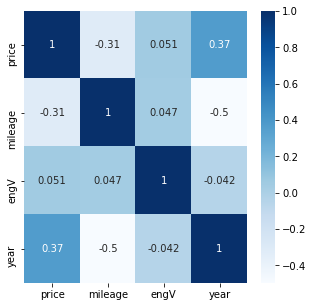

In [276]:
plt.figure(figsize=(5,5))
sns.heatmap(df.corr(), cmap="Blues", annot=True)

Можно увидеть, что объём двигателя и пройденное машиной расстояние плохо коррелируют с ценой.  
Хотя, казалось бы, именно на эти параметры обращают внимание при покупке автомобиля.   
Есть лёгкая корреляция с годом, предположу, что на графике она будет параболой  
т.к. цена будет больше за новые и за очень старые автомобили (раритет

### Узнаем что больше всего влияет на цену

In [277]:
import lightgbm as lgbm

In [278]:
model_research = df[['price', 'body', 'mileage', 'engV', 'engType', 'registration', 'year', 'model', 'drive']]
for column in model_research.select_dtypes(include = ['object']).columns.tolist():
    model_research[column] = model_research[column].astype('category')
lgbm_regressor = lgbm.LGBMRegressor().fit(model_research.loc[:, model_research.columns != 'price'], 
                                          model_research['price'])
list_of_importances = list(zip(model_research.loc[:, model_research.columns != 'price'].columns.tolist(), 
                               lgbm_regressor.feature_importances_))
sorted(list_of_importances, key= lambda x: x[1], reverse= True)

[('engV', 1019),
 ('mileage', 918),
 ('year', 442),
 ('model', 340),
 ('drive', 138),
 ('body', 50),
 ('engType', 49),
 ('registration', 44)]

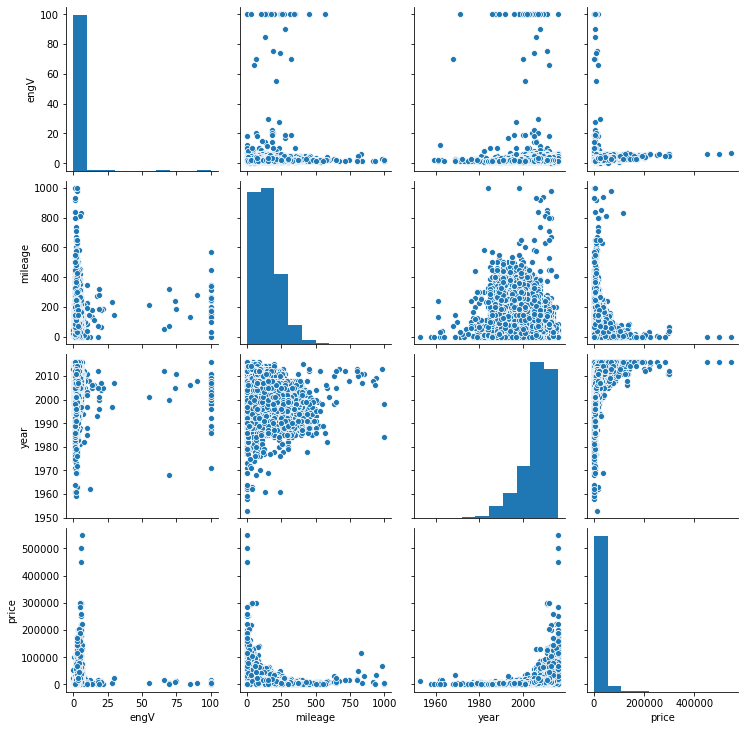

In [279]:
sns.pairplot(model_research[['engV', 'mileage', 'year', 'price']])

Видно, что всё же зависимость от пробега, чем больше машина прошла, тем меньше она стоит.  
Предположу, что engV тоже есть лёгкая зависимость, но она в размерах от 1 до 10 литров объёма двигателя  
т.к. это самый распросранённый объём. Также урежем выбросы цены до 200000 USD.  
Попробуем убрать данные больше и посмотреть ещё.  

In [280]:
model_research = model_research[model_research['engV'] < 10]
model_research = model_research[model_research['price'] < 200000]

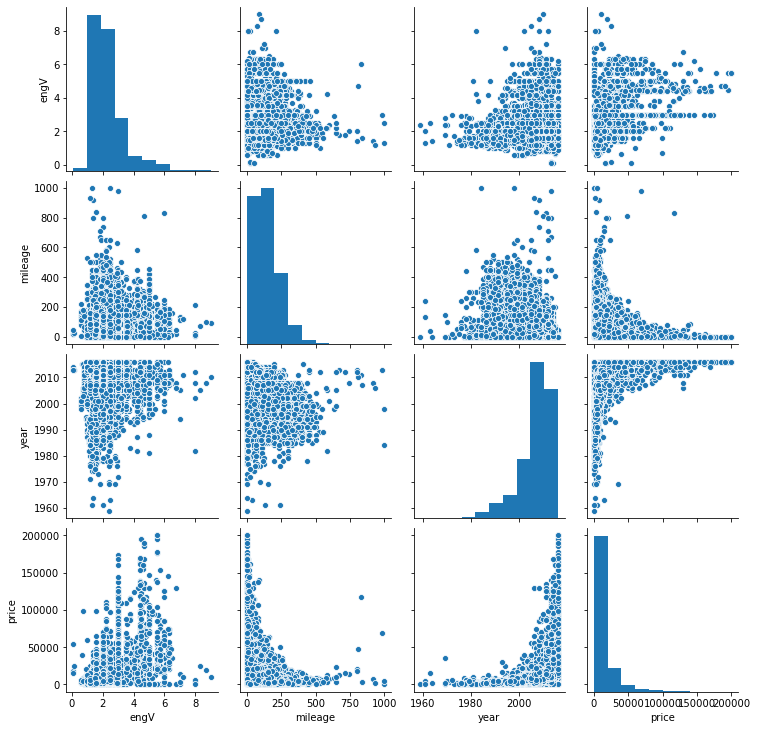

In [281]:
sns.pairplot(model_research[['engV', 'mileage', 'year', 'price']])

In [282]:
price_by_year = df.groupby(by="year").mean()
price_by_year.drop(columns=["engV", "mileage"], inplace=True)
price_by_year.head(10)

,price
year,
1953,11000.000000
1958,0.000000
1959,259.350000
1961,2250.000000
1962,8050.000000
1963,7500.000000
1964,1500.000000
1968,2000.000000
1969,12449.666667


Text(0.5, 0, 'Год')

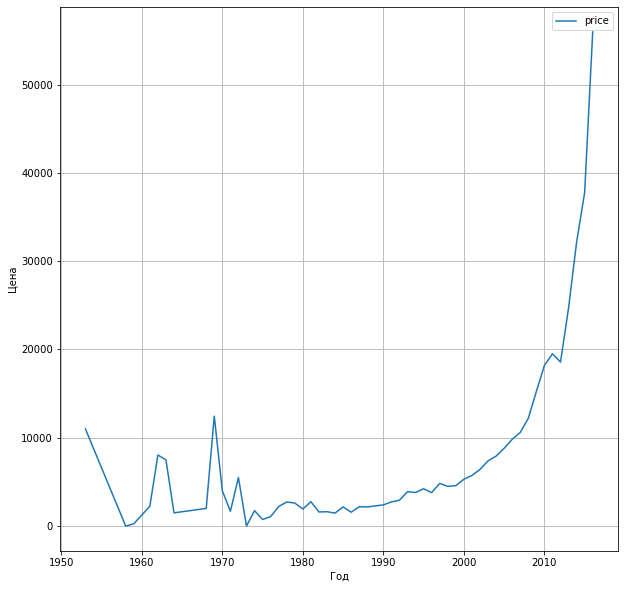

In [283]:
price_by_year = price_by_year.apply(lambda x: x.astype("int"))
price_by_year.plot.line(figsize=(10,10), grid="on");
plt.ylabel("Цена")
plt.xlabel("Год")

In [284]:
by_brand = df.groupby(["car"])

In [285]:
by_brand.head()

,car,price,body,mileage,engV,engType,registration,year,model,drive
0,Ford,15500.00,crossover,68,2.5,Gas,yes,2010,Kuga,full
1,Mercedes-Benz,20500.00,sedan,173,1.8,Gas,yes,2011,E-Class,rear
2,Mercedes-Benz,35000.00,other,135,5.5,Petrol,yes,2008,CL 550,rear
3,Mercedes-Benz,17800.00,van,162,1.8,Diesel,yes,2012,B 180,front
4,Mercedes-Benz,33000.00,vagon,91,NaN,Other,yes,2013,E-Class,NaN
...,...,...,...,...,...,...,...,...,...,...
9398,ËUAZ,1296.75,other,30,1.2,Petrol,yes,1990,969Ì,NaN
9436,Wartburg,1000.00,sedan,90,1.3,Petrol,yes,1989,1.3,front
9448,Buick,3500.00,sedan,190,3.3,Petrol,yes,1990,Century,front
9488,Daihatsu,4500.00,hatch,50,1.0,Petrol,yes,2000,Cuore,front


### Узнаем самый популярный автомобиль в датасете

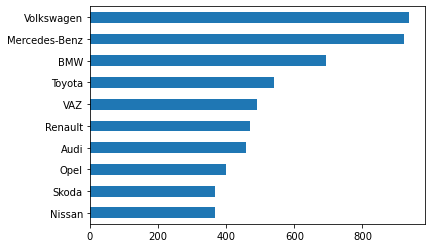

In [378]:
df['car'].value_counts()[:10].sort_values().plot(kind='barh')

In [379]:
df[df['car'] == 'Volkswagen'].count()

car             936
price           936
body            936
mileage         936
engV            907
engType         936
registration    936
year            936
model           936
drive           879
dtype: int64

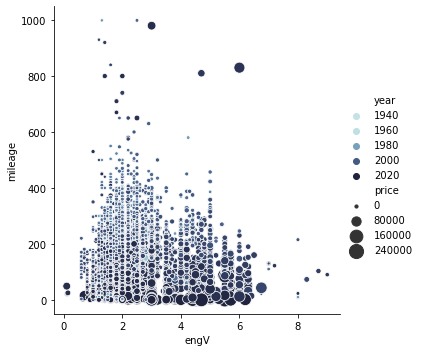

In [386]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
sns.relplot(
    data=model_research,
    x="engV", y="mileage",
    hue="year", size="price",
    palette=cmap, sizes=(10, 200),
)